# Style Transfer

## This program will take the shapes of the content image and the colors and textures of the style image and create a mixed image of the two

reference: https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/15_Style_Transfer.ipynb

## The Setup Part 1: Downloading

In [65]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL.Image
import os
from IPython.display import Image

In [2]:
tf.__version__

'1.1.0'

In [3]:
# displays the progress of the download
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

In [4]:
# used to download the files
def download_and_extract(url, download_dir):

    # combining filename and download_dir
    filename = url.split('/')[-1]
    file_path = os.path.join(download_dir, filename)

    # checks if the file exists
    if not os.path.exists(file_path):
        
        # if the directory doesn't exist it will be downloaded
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)

        # downloading the file from the url
        file_path, _ = urllib.request.urlretrieve(url=url,
                                                  filename=file_path,
                                                  reporthook=download_progress)

        print()
        print("Download finished. Extracting files.")

        if file_path.endswith(".zip"):
            # unpack the zip-file.
            zipfile.ZipFile(file=file_path, mode="r").extractall(download_dir)
        elif file_path.endswith((".tar.gz", ".tgz")):
            # ynpack the tar.
            tarfile.open(name=file_path, mode="r:gz").extractall(download_dir)

        print("Done.")
    else:
        print("Data has already been downloaded and unpacked.")

In [5]:
# downloading the vgg16 model from the url
url="https://s3.amazonaws.com/cadl/models/vgg16.tfmodel"
data_dir = "vgg16/"
download_and_extract(url, data_dir)

Data has already been downloaded and unpacked.


In [6]:
 """
The VGG16 model is a Deep Neural Network which has already been
trained for classifying images into 1000 different categories.
When you create a new instance of this class, the VGG16 model
will be loaded and can be used immediately without training.
"""

path_graph_def="vgg16.tfmodel"

class VGG16:
    
    # tensor used to feed the input image
    tensor_name_input_image = "images:0"

    # tensors for the dropout random-values
    tensor_name_dropout = 'dropout/random_uniform:0'
    tensor_name_dropout1 = 'dropout_1/random_uniform:0'

    # names of the layers in the model
    layer_names = ['conv1_1/conv1_1', 'conv1_2/conv1_2',
                   'conv2_1/conv2_1', 'conv2_2/conv2_2',
                   'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3',
                   'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3',
                   'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

    def __init__(self):
        # load the model from the file and create graph
        self.graph = tf.Graph()

        # set the new graph as the default.
        with self.graph.as_default():

            # tensorflow graphs are saved as Protocol Buffers
            # open graph-def file for binary reading.
            path = os.path.join(data_dir, path_graph_def)
            with tf.gfile.FastGFile(path, 'rb') as file:
                
                # create an empty graph-def (saved copy of a tensorflow graph)
                graph_def = tf.GraphDef()

                # load the proto-buf file into the graph-def
                graph_def.ParseFromString(file.read())

                # import the graph-def to the default TensorFlow graph.
                tf.import_graph_def(graph_def, name='')

                # self.graph holds the VGG16 model from the proto-buf file.

            # getting a reference to the tensor to input images into the graph
            self.input = self.graph.get_tensor_by_name(self.tensor_name_input_image)

            # getting a reference to the tensor for layers that are used the most
            self.layer_tensors = [self.graph.get_tensor_by_name(name + ":0") for name in self.layer_names]

    def get_layer_tensors(self, layer_ids):
        # return a list of references to the tensors for the layers with the given id's.
        return [self.layer_tensors[idx] for idx in layer_ids]

    def get_layer_names(self, layer_ids):
        # return a list of names for the layers with the given id's.
        return [self.layer_names[idx] for idx in layer_ids]

    def get_all_layer_names(self, startswith=None):
        # return a list of all the layers (operations) in the graph.
        #The list can be filtered for names that start with the given string.
        
        # list of the names for all layers (operations) in the graph.
        names = [op.name for op in self.graph.get_operations()]

        # narrowing the list of names to get those starting with the given string
        if startswith is not None:
            names = [name for name in names if name.startswith(startswith)]

        return names

    """
    Create and return a feed-dict with an image.
    :param image:
        The input image is a 3-dim array which is already decoded.
        The pixels MUST be values between 0 and 255 (float or int).
    """
    def create_feed_dict(self, image):

        # expanding 3dim to 4dim by prepending an empty dim because 
        # vgg16 was built for multiple inputs
        image = np.expand_dims(image, axis=0)

        if False:
            # in the original VGG16 model the dropout are fixed to 1.0
            dropout_fix = 1.0

            # creating a feed-dict to input data to tensorflow
            feed_dict = {self.tensor_name_input_image: image,
                         self.tensor_name_dropout: [[dropout_fix]],
                         self.tensor_name_dropout1: [[dropout_fix]]}
        else:
            # creating a feed-dict to input data in tensorflow
            feed_dict = {self.tensor_name_input_image: image}

        return feed_dict

## Setup Part 2: Directory Setup

In [7]:
#creating the directory format
base_path = r'base_image/'
style_path = r'style_image/'
generated_path = r'generated_image/'

# if a directory doensn't exist it will be created
if not os.path.exists(base_path):
    os.makedirs(base_path)
    print("Created directory: base_image\n")
    
if not os.path.exists(style_path):
    os.makedirs(style_path)
    print("Created directory: style_image\n")

if not os.path.exists(generated_path):
    os.makedirs(generated_path)
    print("Created directory: generated_path\n")

print("Directories are ready \n")

print("Insert images in their respective folders: ")
print("base_image folder = The image that you want art applied to")
print("style_image = The art image containing the style")
print("generated_image = The location for the combination of the two images")

Directories are ready 

Insert images in their respective folders: 
base_image folder = The image that you want art applied to
style_image = The art image containing the style
generated_image = The location for the combination of the two images


In [88]:
# gets the names of the images from the user
selection="n"
print("Ex) example.jpg ")
while selection == "n" or selection == "N":
    base_image_name=input('Base image name ')
    style_image_name=input('Style image name ')
    selection=input("are you sure these are the correct name: type (y) for yes or (n) for no ")

print("\n", base_image_name)
print("\n", style_image_name)

Ex) example.jpg 
Base image name dubai.jpg
Style image name starry_night.jpg
are you sure these are the correct name: type (y) for yes or (n) for no y

 dubai.jpg

 starry_night.jpg


## Setup Part 3: Helper Functions

In [89]:
import vgg16

In [90]:
vgg16.data_dir = 'vgg16/'

In [91]:
# loads the image and returns a np array
def load_image(filename, max_size=None):
    image = PIL.Image.open(filename)

    if max_size is not None:
        # calculating the rescale-factor with max height and width
        # while keeping proportions
        factor = max_size / np.max(image.size)
    
        # scaling the height and width
        size = np.array(image.size) * factor

        # converting to an int for PIL
        size = size.astype(int)

        # resizing the image
        image = image.resize(size, PIL.Image.LANCZOS)

    # converting to float point array
    return np.float32(image)

In [92]:
#saves image as jpg
def save_image(image, filename):
    # makes sure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)
    
    # convert to bytes
    image = image.astype(np.uint8)
    
    # saving as a jpeg
    with open(filename, 'w') as file:
        PIL.Image.fromarray(image).save(file, 'jpeg')
        
    print("image saved in generated_image directory")

In [93]:
#displays the image as a large image
def plot_image_big(image):
    # making sure the pixel-values are between 0 and 255.
    image = np.clip(image, 0.0, 255.0)

    # converting pixels to bytes
    image = image.astype(np.uint8)

    # converting to a PIL image and displaying
    display(PIL.Image.fromarray(image))

In [94]:
# used to display the content_image, style_image, and mixed_image at the 
    #during iterations
def plot_images(content_image, style_image, mixed_image):
    
    # create figure with sub-plots.
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    # adjusting vertical spacing.
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # used to smooth pixels
    smooth = True
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    # plotting the content-image.
    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    # plotting the mixed-image.
    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    # plotting the style-image
    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    # removing ticks from all the plots.
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    #displaying the plt
    plt.show()

In [95]:
#calculates the MSE between two tensors
def mean_squared_error(a, b):
    return tf.reduce_mean(tf.square(a - b))

In [96]:
"""
used to transfer the contours from the content image to the generated image
Create the loss-function for the content-image.

Parameters:
session: An open TensorFlow session for running the model's graph.
model: The model, e.g. an instance of the VGG16-class.
content_image: Numpy float array with the content-image.
layer_ids: List of integer id's for the layers to use in the model.
"""
def create_content_loss(session, model, content_image, layer_ids):
    
    # creating a feed-dict for the content-image
    feed_dict = model.create_feed_dict(image=content_image)

    # getting references to the tensors for the paramater layers
    layers = model.get_layer_tensors(layer_ids)

    # calculating the output values of those layers when 
    # feeding the content-image to the model
    values = session.run(layers, feed_dict=feed_dict)

    # setting the model's graph as the default to add computational nodes to it. 
    with model.graph.as_default():
        
        # initialing empty list for loss-functions.
        layer_losses = []
    
        # for each layer and its corresponding values for the content-image.
        for value, layer in zip(values, layers):

            # making sure its a constant 
            value_const = tf.constant(value)

            # loss-function on this layer is MSE 
            loss = mean_squared_error(layer, value_const)

            # adding the loss-function for this layer to the list of loss-functions
            layer_losses.append(loss)

        # the combined loss is the average
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [97]:
#calculates the dot product for the vectors of the feature activations of a style layer
def gram_matrix(tensor):
    
    # getting the shape of the tensor
    shape = tensor.get_shape()
    
    # getting the number of channels for the input tensor
    num_channels = int(shape[3])

    # reshape the tensor so it is a 2-dim matrix similar to Flatten
    matrix = tf.reshape(tensor, shape=[-1, num_channels])
    
    # calculates the dot-products of all combinations of the feature-channels.
    gram = tf.matmul(tf.transpose(matrix), matrix)

    return gram

In [98]:
"""
used to transfer the colors and textures from the style image to the generated image
Create the loss-function for the style-image.

Parameters:
session: An open TensorFlow session for running the model's graph.
model: The model, e.g. an instance of the VGG16-class.
style_image: Numpy float array with the style-image.
layer_ids: List of integer id's for the layers to use in the model.
"""

def create_style_loss(session, model, style_image, layer_ids):

    # creating a feed-dict for the style-image
    feed_dict = model.create_feed_dict(image=style_image)

    # getting references to the tensors for the parameter layers
    layers = model.get_layer_tensors(layer_ids)

    # setting the model's graph as the default to add computational nodes to it. 
    with model.graph.as_default():
        
        # creating the tensorflow operations to calculate the gram matrices (each layer)
        gram_layers = [gram_matrix(layer) for layer in layers]

        # calculating the gram matrices with the style-image
        values = session.run(gram_layers, feed_dict=feed_dict)

        # initializing an empty list of loss-functions.
        layer_losses = []
    
        # for each Gram-matrix layer and its corresponding values.
        for value, gram_layer in zip(values, gram_layers):
            
            # making sure its a constant value
            value_const = tf.constant(value)

            # loss function on layer is a MSE betweenn gram matrix
            loss = mean_squared_error(gram_layer, value_const)

            # add the loss funciton to the list of loss functions
            layer_losses.append(loss)

        # the combined loss is the average
        total_loss = tf.reduce_mean(layer_losses)
        
    return total_loss

In [99]:
#creates a loss function to denoise the mixed image. 
#shifts image one pixel->calculates the difference between that shifted and original image->
    #takes the absolute value->sums all pixels in the image
def create_denoise_loss(model):
    loss = tf.reduce_sum(tf.abs(model.input[:,1:,:,:] - model.input[:,:-1,:,:])) + \
           tf.reduce_sum(tf.abs(model.input[:,:,1:,:] - model.input[:,:,:-1,:]))

    return loss

In [100]:
"""
Use gradient descent to find an image that minimizes the
loss-functions of the content-layers and style-layers. This
should result in a mixed-image that resembles the contours
of the content-image, and resembles the colours and textures
of the style-image.

Parameters:
content_image: Numpy 3-dim float-array with the content-image.
style_image: Numpy 3-dim float-array with the style-image.
content_layer_ids: List of integers identifying the content-layers.
style_layer_ids: List of integers identifying the style-layers.
weight_content: Weight for the content-loss-function.
weight_style: Weight for the style-loss-function.
weight_denoise: Weight for the denoising-loss-function.
num_iterations: Number of optimization iterations to perform.
step_size: Step-size for the gradient in each iteration.
"""

def style_transfer(content_image, style_image,
                   content_layer_ids, style_layer_ids,
                   weight_content, weight_style,
                   weight_denoise,
                   num_iterations, step_size):

    # creating an instance of the model 
    model = VGG16()

    # creating a tensorflow session
    session = tf.InteractiveSession(graph=model.graph)

    # printing the content layer names
    print("Content layers:")
    print(model.get_layer_names(content_layer_ids))
    print()

    # printing the style layer names
    print("Style layers:")
    print(model.get_layer_names(style_layer_ids))
    print()

    # creating the loss-function for content layer
    loss_content = create_content_loss(session=session,
                                       model=model,
                                       content_image=content_image,
                                       layer_ids=content_layer_ids)

    # creating the loss-function for the style layers
    loss_style = create_style_loss(session=session,
                                   model=model,
                                   style_image=style_image,
                                   layer_ids=style_layer_ids)    

    # creating the loss-function to denoise the generated image
    loss_denoise = create_denoise_loss(model)

    # creating tf variables to adjust the loss-function values
    adj_content = tf.Variable(1e-10, name='adj_content')
    adj_style = tf.Variable(1e-10, name='adj_style')
    adj_denoise = tf.Variable(1e-10, name='adj_denoise')

    # initialize the adjustment values for the loss-functions.
    session.run([adj_content.initializer,
                 adj_style.initializer,
                 adj_denoise.initializer])

    # create TensorFlow operations for updating the adjustment values.
    # these are basically just the reciprocal values of the
    # loss-functions, with a small value 1e-10 added to avoid the
    # possibility of division by zero.
    update_adj_content = adj_content.assign(1.0 / (loss_content + 1e-10))
    update_adj_style = adj_style.assign(1.0 / (loss_style + 1e-10))
    update_adj_denoise = adj_denoise.assign(1.0 / (loss_denoise + 1e-10))

    # weighted loss function to minimize to generate mixed-image
    loss_combined = weight_content * adj_content * loss_content + \
                    weight_style * adj_style * loss_style + \
                    weight_denoise * adj_denoise * loss_denoise

    # getting gradient of the combined loss function with input image
    gradient = tf.gradients(loss_combined, model.input)

    # tensor list to run in each optimization iteration
    run_list = [gradient, update_adj_content, update_adj_style, \
                update_adj_denoise]

    # generated image (same size as content-image) has random noise. 
    mixed_image = np.random.rand(*content_image.shape) + 128

    for i in range(num_iterations):
        
        # feed-dict for the mixed-image
        feed_dict = model.create_feed_dict(image=mixed_image)

        # calculating the gradient and updating the adjustment values
        grad, adj_content_val, adj_style_val, adj_denoise_val \
        = session.run(run_list, feed_dict=feed_dict)

        # reducing the dim of the gradent
        grad = np.squeeze(grad)

        # scaling the step size based on the gradient
        step_size_scaled = step_size / (np.std(grad) + 1e-8)

        # updating the image by following the gradient
        mixed_image -= grad * step_size_scaled

        # making sure the pixels are between 0 and 255
        mixed_image = np.clip(mixed_image, 0.0, 255.0)

        # printing the progress 
        print(". ", end="")

        # displaying progress every 10 iterations, and last
        if (i % 10 == 0) or (i == num_iterations - 1):
            print()
            print("Iteration:", i)

            # printing adjustment weights for loss-functions
            msg = "Weight Adj. for Content: {0:.2e}, Style: {1:.2e}, Denoise: {2:.2e}"
            print(msg.format(adj_content_val, adj_style_val, adj_denoise_val))

            # plotting the images
            plot_images(content_image=content_image,
                        style_image=style_image,
                        mixed_image=mixed_image)
            
    print()
    print("Final image:")
    plot_image_big(mixed_image)

    # closing the session 
    session.close()
    
    return mixed_image

content path:  base_image/dubai.jpg


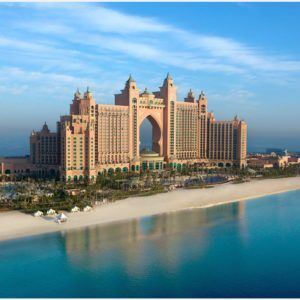

In [101]:
# loading the content image that is going to have the contours of the generated image
content_filename = os.path.join('base_image/' + base_image_name)
print("content path: ", content_filename)
content_image = load_image(content_filename, max_size=None)
Image(content_filename)

style path:  style_image/starry_night.jpg


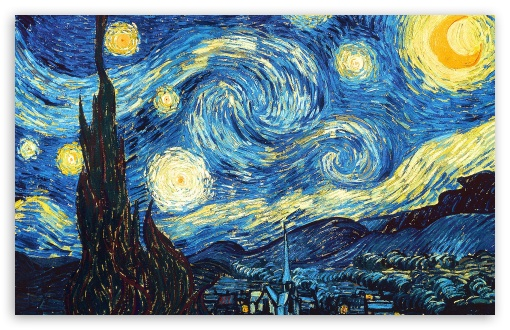

In [102]:
# loading the style image that is going to have the colors and texture of the generated image
style_filename = os.path.join('style_image/' + style_image_name)
print("style path: ", style_filename)
style_image = load_image(style_filename, max_size=None) #max_size=300
Image(style_filename)

In [103]:
# identifying which layer in the vgg16 model will be used to match the content image
content_layer_ids = [4]

In [104]:
# identifying which layers will be used to match the style image
# the 13 CNN layers in VGG16 will be selected as style-layers
style_layer_ids = list(range(13))

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.05e-11, Style: 1.17e-29, Denoise: 5.58e-06


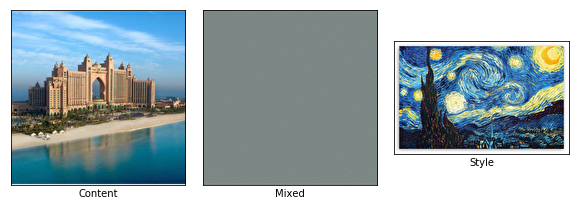

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 5.90e-11, Style: 4.00e-29, Denoise: 1.22e-07


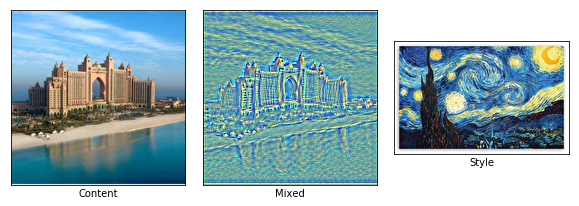

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 2.41e-11, Style: 2.38e-28, Denoise: 8.41e-08


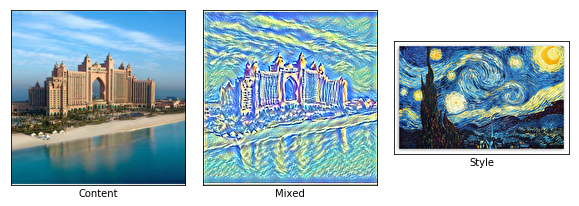

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 2.40e-11, Style: 4.36e-28, Denoise: 8.68e-08


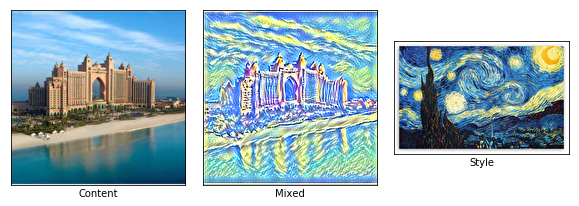

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 2.34e-11, Style: 6.73e-28, Denoise: 8.60e-08


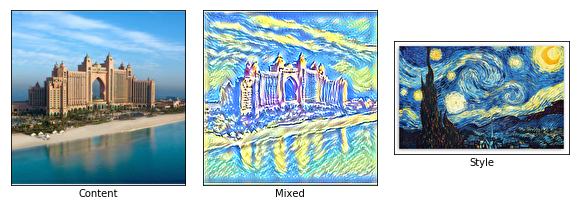

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 2.25e-11, Style: 9.12e-28, Denoise: 8.39e-08


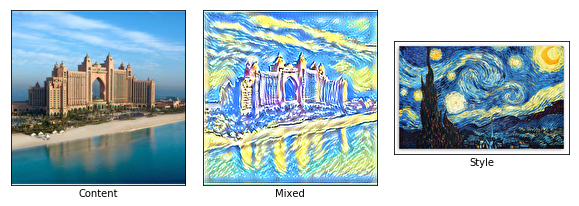

. . . . . . . . . . 
Iteration: 60
Weight Adj. for Content: 2.12e-11, Style: 1.12e-27, Denoise: 8.06e-08


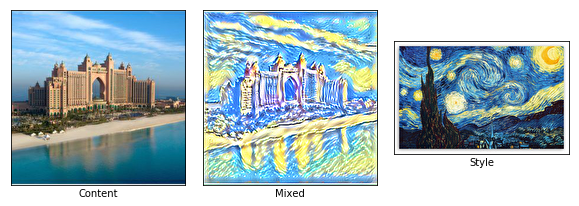

. . . . . . . . . . 
Iteration: 70
Weight Adj. for Content: 2.14e-11, Style: 1.69e-27, Denoise: 8.15e-08


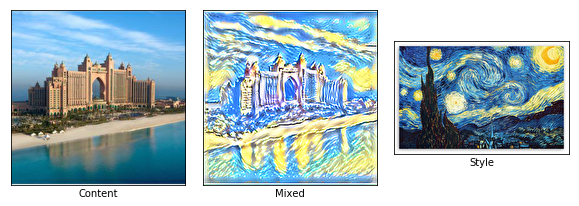

. . . . . . . . . . 
Iteration: 80
Weight Adj. for Content: 2.10e-11, Style: 1.83e-27, Denoise: 8.12e-08


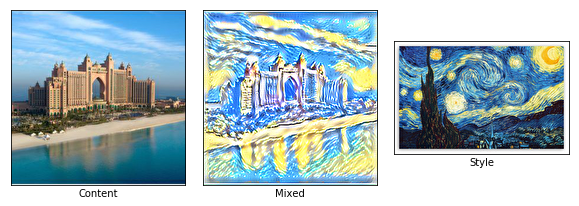

. . . . . . . . . . 
Iteration: 90
Weight Adj. for Content: 2.06e-11, Style: 1.78e-27, Denoise: 8.02e-08


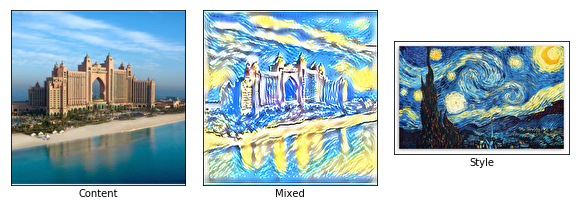

. . . . . . . . . 
Iteration: 99
Weight Adj. for Content: 2.39e-11, Style: 9.37e-28, Denoise: 8.71e-08


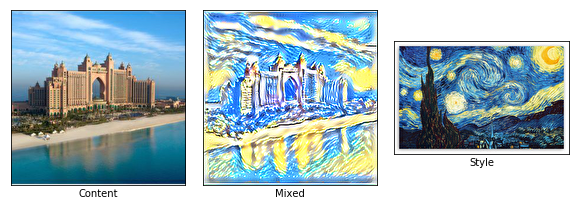


Final image:


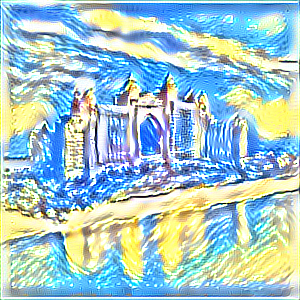

In [105]:
# performing the style transfer
img = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.0,
                     weight_style=11.0,
                     weight_denoise=0.3,
                     num_iterations=100,
                     step_size=5.0)

In [106]:
image_directory='generated_image/mixed_image.jpg'
save_image(img, image_directory)

image saved in generated_image directory


## Comparison to Hvass Parameters

Content layers:
['conv3_1/conv3_1']

Style layers:
['conv1_1/conv1_1', 'conv1_2/conv1_2', 'conv2_1/conv2_1', 'conv2_2/conv2_2', 'conv3_1/conv3_1', 'conv3_2/conv3_2', 'conv3_3/conv3_3', 'conv4_1/conv4_1', 'conv4_2/conv4_2', 'conv4_3/conv4_3', 'conv5_1/conv5_1', 'conv5_2/conv5_2', 'conv5_3/conv5_3']

. 
Iteration: 0
Weight Adj. for Content: 6.05e-11, Style: 1.17e-29, Denoise: 5.57e-06


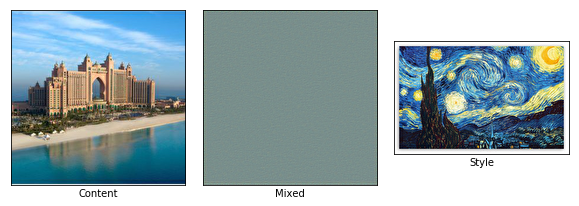

. . . . . . . . . . 
Iteration: 10
Weight Adj. for Content: 2.81e-11, Style: 1.37e-28, Denoise: 7.69e-08


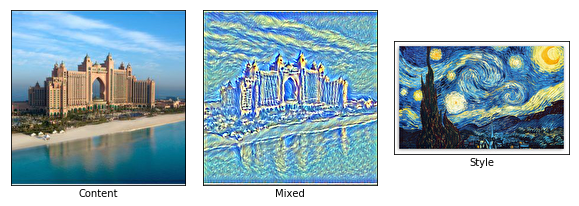

. . . . . . . . . . 
Iteration: 20
Weight Adj. for Content: 2.41e-11, Style: 3.11e-28, Denoise: 7.53e-08


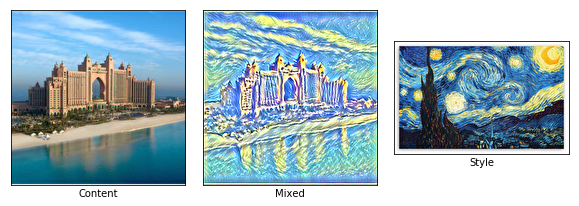

. . . . . . . . . . 
Iteration: 30
Weight Adj. for Content: 2.26e-11, Style: 4.22e-28, Denoise: 7.37e-08


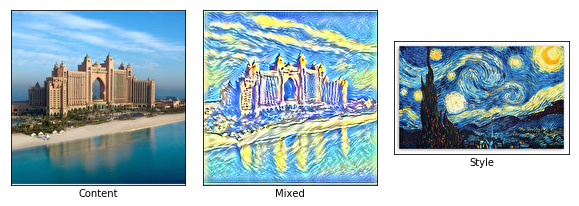

. . . . . . . . . . 
Iteration: 40
Weight Adj. for Content: 2.09e-11, Style: 3.28e-28, Denoise: 7.03e-08


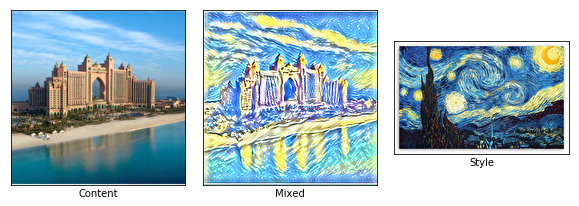

. . . . . . . . . . 
Iteration: 50
Weight Adj. for Content: 2.07e-11, Style: 5.02e-28, Denoise: 7.06e-08


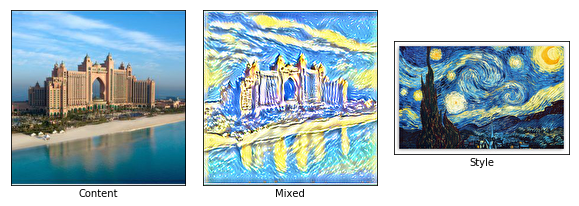

. . . . . . . . . 
Iteration: 59
Weight Adj. for Content: 2.62e-11, Style: 6.25e-28, Denoise: 7.95e-08


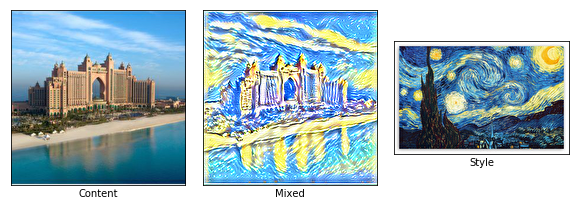


Final image:


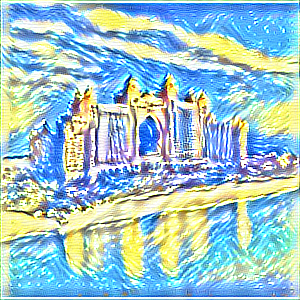

In [107]:
img2 = style_transfer(content_image=content_image,
                     style_image=style_image,
                     content_layer_ids=content_layer_ids,
                     style_layer_ids=style_layer_ids,
                     weight_content=1.5,
                     weight_style=10.0,
                     weight_denoise=0.3,
                     num_iterations=60,
                     step_size=10.0)

In [108]:
image_directory='generated_image/Hvass.jpg'
save_image(img2, image_directory)

image saved in generated_image directory
